In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import os
import sys
import random
import seaborn as sns
from matplotlib.font_manager import FontProperties
font1 = FontProperties(fname=r"C:\\Windows\\Fonts\\STZHONGS.ttf", size=14)
font2 = FontProperties(fname=r"C:\\Windows\\Fonts\\STZHONGS.ttf", size=12)
font3 = FontProperties(fname=r"C:\\Windows\\Fonts\\STZHONGS.ttf", size=10)
font4 = FontProperties(fname=r"C:\\Windows\\Fonts\\STZHONGS.ttf", size=7)
sns.set_style('whitegrid')
sns.set_palette("muted")
random.seed(20241130)
np.random.seed(20241130)
torch.manual_seed(3407) # Torch.manual_seed(3407) is all you need. Paper: http://arxiv.org/abs/2109.08203
# 修改工作路径，使本.ipynb文件能够像在本文件夹根目录下一样导入其他模块
# Modify the working path so that this.ipynb file can import other modules like in the root directory
current_dir = os.path.dirname(os.path.abspath('__file__'))
sys.path.append(os.path.join(current_dir, '..'))

In [ ]:
df_whole=pd.read_excel("E:\\科创优才\\实验数据\\天然气锅炉数据1.xlsx", sheet_name="稳定运行数据段")
units=df_whole.iloc[0].tolist()
df=df_whole.iloc[2:].reset_index(drop=True)

# 重命名所有列名，缩短名称长度，方便使用
df.columns=[
    '开始时间',
    '主蒸汽流量计算值',
    '烟气含氧量（CEMS）',
    '颗粒浓度',
    '二氧化硫',
    'NO浓度',
    'NO2浓度',
    'NOX标干浓度',
    'NOX浓度',
    '烟气湿度（CEMS）',
    '烟气压力（CEMS）',
    '烟气温度（CEMS）',
    '一氧化碳',
    '锅炉天然气进气流量',
    '锅炉天然气进气温度',
    '锅炉天然气进气压力',
    '鼓风机出口温度',
    '鼓风机出口压力',
    '鼓风机变频器输出反馈',
    '鼓风机变频器电流反馈',
    '再循环烟气调节阀反馈',
    '冷凝器出口烟气调节阀反馈',
    '炉膛出口烟气温度（B分度）',
    '炉膛出口烟气压力',
    'SWY大气压',
    'SWY天气温度',
    'SWY空气湿度',
    'SWY湿球温度',
    '主蒸汽温度(蒸汽集箱出口温度）',
    '主蒸汽压力(蒸汽集箱出口压力）',
    '分汽缸温度',
    '分汽缸压力',
    '分汽缸出口至DN400蒸汽温度',
    '过热器集箱出口蒸汽温度',
    '天然气累计流量',
    '冷凝器烟气流量（累计值）',
    '冷凝器出口烟气流量',
    '冷凝器出口烟气温度'
]

# 将可能用到的变量名和单位存入字典
var_dict={
    "主蒸汽流量计算值": "t/h",
    "烟气含氧量（CEMS）": "mg/Nm3",
    "NO浓度": "mg/Nm3",
    "NO2浓度": "mg/Nm3",
    "NOX浓度": "mg/Nm3",
    "烟气湿度（CEMS）": "%",
    "烟气压力（CEMS）": "Pa",
    "烟气温度（CEMS）": "℃",
    "一氧化碳": "mg/Nm3",
    "锅炉天然气进气流量": "m3/h",
    "锅炉天然气进气温度": "℃",
    "锅炉天然气进气压力": "kPa",
    '鼓风机出口温度': "℃",
    "鼓风机出口压力": "kPa",
    "鼓风机变频器输出反馈": "Hz",
    "鼓风机变频器电流反馈": "A",
    "冷凝器出口烟气调节阀反馈": "%",
    "炉膛出口烟气压力": "Pa",
    "SWY大气压": "kPa",
    "SWY天气温度": "℃",
    "SWY空气湿度": "%",
    'SWY湿球温度': "℃",
    '主蒸汽温度(蒸汽集箱出口温度）': "℃",
    "主蒸汽压力(蒸汽集箱出口压力）": "MPa",
    "分汽缸温度": "℃",
    "分汽缸压力": "MPa",
    '分汽缸出口至DN400蒸汽温度': "℃",
    '过热器集箱出口蒸汽温度': "℃",
    "冷凝器出口烟气流量": "Nm3/h",
    "冷凝器出口烟气温度": "℃",
}
var_names=list(var_dict.keys())

# 定义输入变量
input_var_names=[
    "主蒸汽流量计算值",
    "锅炉天然气进气流量",
    "锅炉天然气进气温度",
    "锅炉天然气进气压力",
    '鼓风机出口温度',
    "鼓风机出口压力",
    "鼓风机变频器输出反馈",
    "鼓风机变频器电流反馈",
    "冷凝器出口烟气调节阀反馈",
    "SWY大气压",
    "SWY天气温度",
    "SWY空气湿度",
    'SWY湿球温度',
    "主蒸汽温度(蒸汽集箱出口温度）",
    "主蒸汽压力(蒸汽集箱出口压力）",
]

# 定义输出变量
output_var_names=[
    "烟气含氧量（CEMS）",
    #NO浓度",
    #"NO2浓度", # 主要预测NO，因为NO2的准确性有待考量
    "NOX浓度",
    "烟气湿度（CEMS）",
    "烟气压力（CEMS）",
    "烟气温度（CEMS）",
    "一氧化碳",
    #"炉膛出口烟气压力",

    #暂时不考虑以下输出变量
    #"分汽缸温度",
    #"分汽缸压力",
    #"分汽缸出口至DN400蒸汽温度",
    #"过热器集箱出口蒸汽温度",
    #"冷凝器出口烟气流量",
    #"冷凝器出口烟气温度",
]

input_var_dict={name:var_dict[name] for name in input_var_names}
output_var_dict={name:var_dict[name] for name in output_var_names}

var_units=list(var_dict.values())
input_var_units=list(input_var_dict.values())
output_var_units=list(output_var_dict.values())

input_var_indices=[var_names.index(name) for name in input_var_names]
output_var_indices=[var_names.index(name) for name in output_var_names]

data_np=df[var_names].to_numpy(dtype=float)

'''
# 通过不同切片增加数据量
DATA=[
    data_np,
    data_np[:30,:],
    data_np[:50,:],
    data_np[:100,:],
    data_np[:800,:],
    data_np[100:850,:],
    data_np[200:900,:],
    data_np[300:950,:],
    data_np[400:1000,:],
    ]
'''

'''
# 通过不同切片增加数据量
DATA=[
    data_np[:200,:],
    data_np[200:400,:],
    data_np[400:600,:],
    data_np[600:800,:],
    data_np[800:1000,:],
    data_np[1000:,:]
    ]
'''

DATA=[
    data_np[:100,:],
    data_np[100:200,:],
    data_np[200:300,:],
    data_np[300:400,:],
    data_np[400:500,:],
    data_np[500:600,:],
    data_np[600:700,:],
    data_np[700:800,:],
    data_np[800:900,:],
    data_np[900:1000,:],
    data_np[1000:,:],
    ]



print("data_np.shape:", data_np.shape)

data_np.shape: (1124, 30)


In [3]:
# Hyperparameters
num_epochs = 100 # maximum number of epochs to train, if early stopping is not triggered
learning_rate = 0.001
input_len = 1
output_len = 1
overlap=1 # The last time step of the input sequence is the first time step of the output sequence.
label_len = 0 # label_len should be set only for decoder-based models, or there is potential risk of data leakage.
input_channels = len(input_var_names)
output_channels = len(output_var_names)
batch_size = 32
device = 'cpu'  # 设备
#device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
from gas_data_prediction.data_preprocessing import GasData

DATASET=GasData(DATA,
                input_len=input_len,
                output_len=output_len,
                overlap=overlap,
                input_indices=input_var_indices,
                output_indices=output_var_indices,
                var_names=var_names,
                var_units=var_units)

transformed_data, \
    (var_mean, var_std_dev), \
    (input_var_mean, input_var_std_dev), \
    (output_var_mean, output_var_std_dev) \
        = DATASET.standardize()

DATASET.train_test_split()

(X_train_grouped, Y_train_grouped), (X_test_grouped, Y_test_grouped) = DATASET.time_series_slice()
(X_train, Y_train), (X_test, Y_test) = DATASET.build_train_test_set()



input_var_mean:
 [  20.2454 1331.8977   13.2356   46.8861   38.3970    4.5339   35.0048  152.1584  100.0357   95.5487    6.4956   87.2198    5.4213  238.3648    0.8011]
input_var_std_dev:
 [  5.3007 346.8931   1.0821   0.6402   1.9454   0.6694   3.4072  31.4429   0.0128   0.1913   1.8839  15.3245   1.0358   6.6171   0.0404]
output_var_mean:
 [13.0202]
output_var_std_dev:
 [3.3859]
train data indices: [10, 8, 7, 0, 6, 2, 3, 5]
test data indices: [1, 4, 9]
num_train: 8
num_test: 3
len(X_train_grouped): 8
len(Y_train_grouped): 8
len(X_test_grouped): 3
len(Y_test_grouped): 3
X_train.shape: (816, 1, 15)
Y_train.shape: (816, 1, 1)
X_test.shape: (297, 1, 15)
Y_test.shape: (297, 1, 1)


In [5]:
from models.LR import LinearRegression, Ridge, Lasso, ElasticNet
from models.SVR import SVR, LinearSVR, NuSVR

shared_params = {
    'input_len': input_len,
    'output_len': output_len,
    'input_channels': input_channels,
    'output_channels': output_channels,
}
model_0 = LinearRegression(**shared_params)
model_1 = Ridge(**shared_params,alpha=1.0)
model_2 = Lasso(**shared_params,alpha=0.1)
model_3 = ElasticNet(**shared_params,alpha=0.01,l1_ratio=0.05)
model_4 = SVR(**shared_params,C=12.5,epsilon=0.1)
model_5 = LinearSVR(**shared_params,C=1.0)
model_6 = NuSVR(**shared_params,C=1.0,nu=0.5)

model=model_4 # change this to try different models
model.fit(X_train,Y_train)


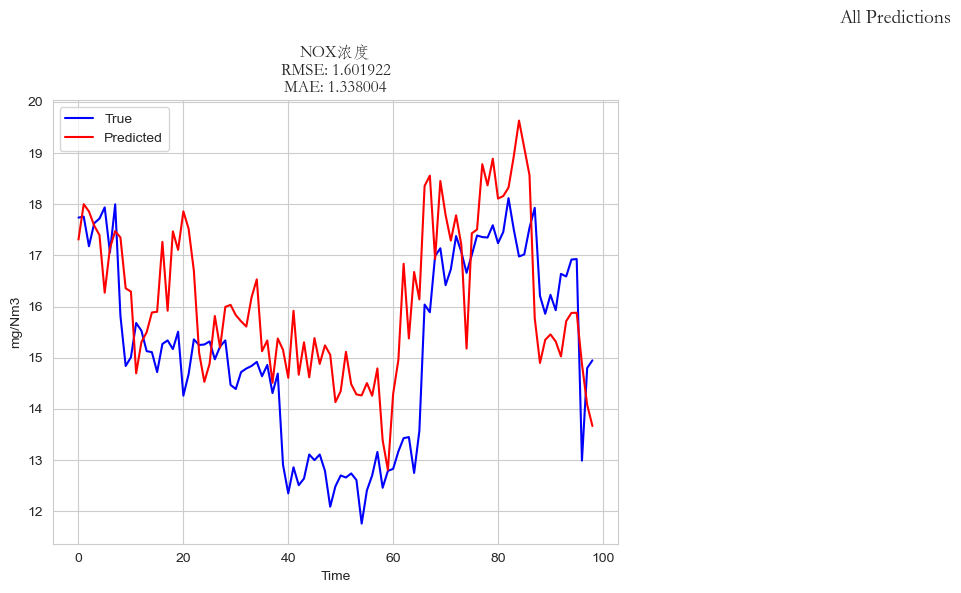

In [6]:
from gas_data_prediction.utils import ModelTest
Exp=ModelTest(model, DATASET, device=device) # Experiment object initialization
Y_pred, Y_true = Exp.get_pred_true_pairs(X_test_grouped[2], Y_test_grouped[2], with_Tensor=False)
Exp.plot_all_predictions(Y_pred, Y_true, plot_residual=0, rescale=1, figsize=(18, 6))

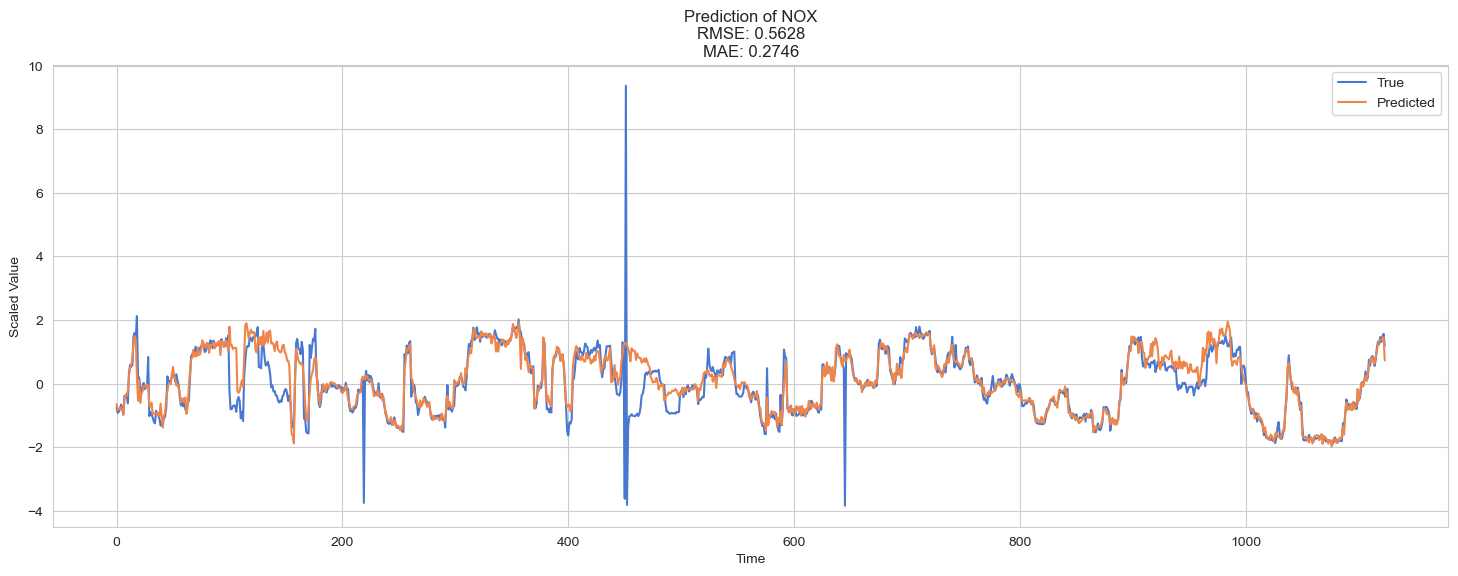

In [7]:
X=data_np[:,input_var_indices]
Y=data_np[:,output_var_indices]

X_standardized=DATASET.standardize_2d_np(X, mode="input")
Y_standardized=DATASET.standardize_2d_np(Y, mode="output")

X_standardized=X_standardized.reshape(X_standardized.shape[0], 1, X_standardized.shape[1])
Y_standardized=Y_standardized.reshape(Y_standardized.shape[0], 1, Y_standardized.shape[1])

Y_pred_standardized=model(X_standardized)
Y_pred=DATASET.inverse_standardize_2d_np(Y_pred_standardized.reshape(Y_pred_standardized.shape[0], -1), mode="output")

plt.figure(figsize=(18, 6))
plt.title('Prediction of {}\nRMSE: {:.4f}\nMAE: {:.4f}'.format(
        'NOX',
        ((Y_standardized-Y_pred_standardized)**2).mean()**0.5,
        (np.abs(Y_standardized-Y_pred_standardized)).mean()))
plt.plot(Y_standardized.squeeze())
plt.plot(Y_pred_standardized.squeeze())
plt.xlabel('Time')
plt.ylabel('Scaled Value')
plt.legend(['True', 'Predicted'])
plt.show()

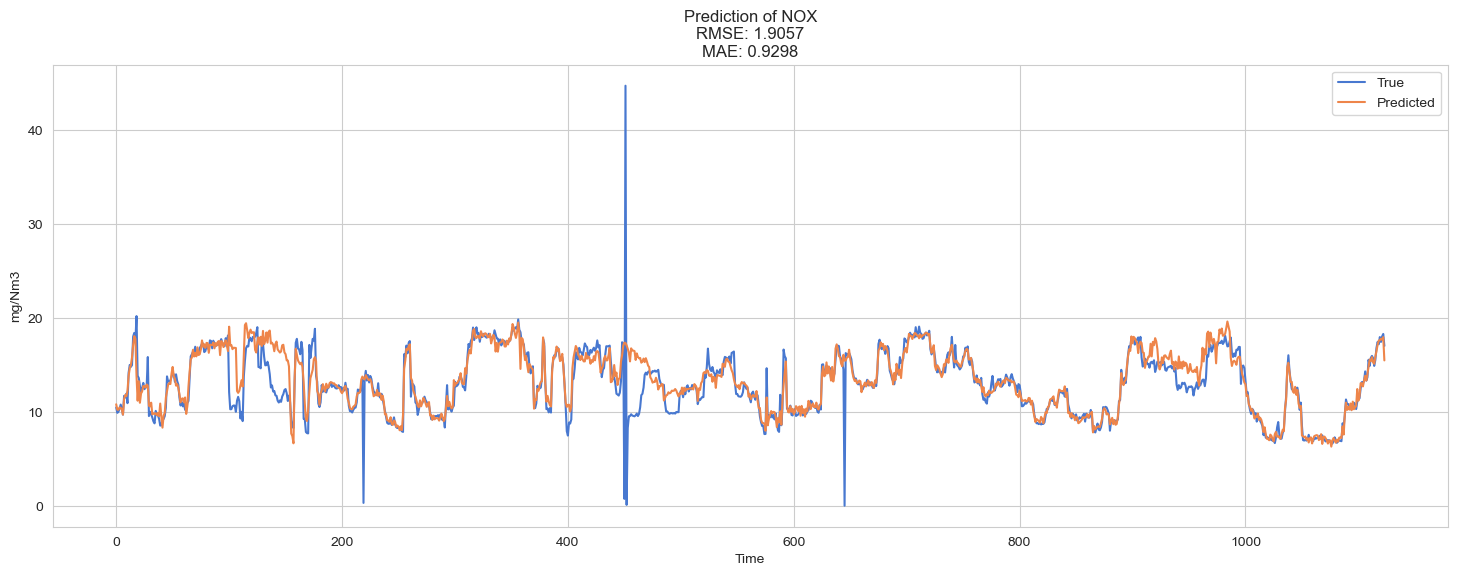

In [8]:
plt.figure(figsize=(18, 6))
plt.title('Prediction of {}\nRMSE: {:.4f}\nMAE: {:.4f}'.format(
    'NOX',
    ((Y-Y_pred)**2).mean()**0.5,
    (np.abs(Y-Y_pred)).mean()))
plt.plot(Y.squeeze())
plt.plot(Y_pred.squeeze())
plt.xlabel('Time')
plt.ylabel('mg/Nm3')
plt.legend(['True', 'Predicted'])
plt.show()

In [9]:
np.set_printoptions(precision=4, suppress=True)

# 示例数组
arr = np.array([0.000123456, 1.23456789, 12345.6789, 0.00000987654321])

print(arr)

[    0.0001     1.2346 12345.6789     0.0000]


In [11]:
Exp.get_prediction_info(X_test_grouped, Y_test_grouped)

,unit,RMSE,RMSE_standard,MAE,MAE_standard
NOX浓度,mg/Nm3,3.316782,0.979588,2.093027,0.61816
